In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
!pip install uproot awkward 
from uproot_io import Events, View
import features as f
from sklearn.cluster import DBSCAN

In [2]:
events_unseen = Events('CheatedRecoFile_5.root')

In [3]:
# Load the histogram data
correlation_data = np.load("Correlation_pdf.npz")  # Load correlation histogram data
noise_data = np.load("Noise_pdf.npz")  # Load noise histogram data
rms_data = np.load("RMS_pdf.npz")  # Load rms histogram data
q4_data = np.load("Q4_pdf.npz")  # Load Q4 histogram data
line_data = np.load("Line_pdf.npz")  # Load line integrals histogram data
angle_data = np.load("angles_histogram_data.npz")  # angle histo

# Access the data for correlation
correlation_bin_edges = correlation_data['bin_edges']  # Access bin edges
correlation_track_counts = correlation_data['track_bin_heights']  # Access track counts
correlation_shower_counts = correlation_data['shower_bin_heights']  # Access shower counts

# Access the data for noise
noise_bin_edges = noise_data['bin_edges']  # Access bin edges
noise_track_counts = noise_data['track_bin_heights']  # Access track counts
noise_shower_counts = noise_data['shower_bin_heights']  # Access shower counts

# Access the data for RMS
rms_bin_edges = rms_data['bin_edges']  # Access bin edges
rms_track_counts = rms_data['track_bin_heights']  # Access track counts
rms_shower_counts = rms_data['shower_bin_heights']  # Access shower counts

# Access the data for line integrals
line_bin_edges = line_data['bin_edges']  # Access bin edges
line_track_counts = line_data['track_bin_heights']  # Access track counts
line_shower_counts = line_data['shower_bin_heights']  # Access shower counts

# Access the data for Q4
q4_bin_edges = q4_data['bin_edges']  # Access bin edges
q4_track_counts = q4_data['track_bin_heights']  # Access track counts
q4_shower_counts = q4_data['shower_bin_heights']  # Access shower counts

# Access the data for angle
angle_bin_edges = angle_data['track_bin_edges']  # Access bin edges
angle_track_counts = angle_data['track_counts']  # Access track counts
angle_shower_counts = angle_data['shower_counts']  # Access shower counts

In [4]:
#COPIED FROM GEN'S CODE
shower_pdg_set = {11, -11, 22, -22}  # Define PDG codes for showers
def get_probabilities_from_histogram(score, bin_edges, track_counts, shower_counts):
    """Returns both track and shower probabilities for a given score"""
    bin_index = np.digitize(score, bin_edges) - 1  # Find the bin index for the score
    if bin_index < 0 or bin_index >= len(track_counts):
        return 0, 0  # If score is out of range, return 0 for both probabilities
    return track_counts[bin_index], shower_counts[bin_index]  # Return both probabilities

def categorise_event(events, event_idx, shower_pdg_set):
    # Extract PDG code
    pdg_code = events.mc_pdg[event_idx]  # Assuming this holds a single PDG code
    
    # Determine if event is a shower or track
    if pdg_code in shower_pdg_set:
        return 'shower'
    else:
        return 'track'  # All other PDG codes are considered as track

# Getting Scores from correct Likelihood
def likelihood_approach(events, event_idx, shower_pdg_set):
    """Applies the likelihood approach for an unseen event."""
    # Calculate correlation and noise scores
    correlation_score = f.correlation(events, event_idx)
    noise_score = f.noise(events, event_idx)
    rms_score = f.rms(events, event_idx)
    line_score = f.line(events, event_idx)
    q4_score = f.q4_ratio(events, event_idx)
    angle_score = f.angle(events, event_idx)

    # Ensure valid scores
    if correlation_score is None or noise_score is None:
        return None

    # Get probabilities from correlation histogram
    prob_correlation_track, prob_correlation_shower = get_probabilities_from_histogram(
        correlation_score, correlation_bin_edges, correlation_track_counts, correlation_shower_counts
    )

    # Get probabilities from noise histogram
    prob_noise_track, prob_noise_shower = get_probabilities_from_histogram(
        noise_score, noise_bin_edges, noise_track_counts, noise_shower_counts
    )

    # Get probabilities from RMS histogram
    prob_rms_track, prob_rms_shower = get_probabilities_from_histogram(
        rms_score, rms_bin_edges, rms_track_counts, rms_shower_counts
    )

    # Get probabilities from line histogram
    prob_line_track, prob_line_shower = get_probabilities_from_histogram(
        line_score, line_bin_edges, line_track_counts, line_shower_counts
    )

    # Get probabilities from q4 histogram
    prob_q4_track, prob_q4_shower = get_probabilities_from_histogram(
        q4_score, q4_bin_edges, q4_track_counts, q4_shower_counts
    )

    # Get probabilities from angle histogram
    prob_angle_track, prob_angle_shower = get_probabilities_from_histogram(
        angle_score, angle_bin_edges, angle_track_counts, angle_shower_counts
    )

    # Compute likelihoods
    likelihood_track = (prob_correlation_track * prob_noise_track * prob_rms_track *
                         prob_line_track * prob_q4_track * prob_angle_track)
    likelihood_shower = (prob_correlation_shower * prob_noise_shower * prob_rms_shower *
                         prob_line_shower * prob_q4_shower * prob_angle_shower)

    # Normalize to get posterior probabilities
    total_likelihood = likelihood_track + likelihood_shower
    if total_likelihood == 0:
        return None

    Track_L = likelihood_track / total_likelihood
    Shower_L = likelihood_shower / total_likelihood

    # Determine preliminary classification using the categorise_event function
    prelim_classification = categorise_event(events, event_idx, shower_pdg_set)

    # Return Track_L and its classification
    return Track_L, Shower_L, prelim_classification




# Main script to process events and plot
likelihoods = []  # List to store (Track_L, Track_S, classification) for all events

# Process each event
for event_idx in range(len(events_unseen.reco_hits_w)):
    if len(events_unseen.reco_hits_w[event_idx]) > 15:
        result = likelihood_approach(events_unseen, event_idx, shower_pdg_set)
        if result is not None:
            likelihoods.append(result)


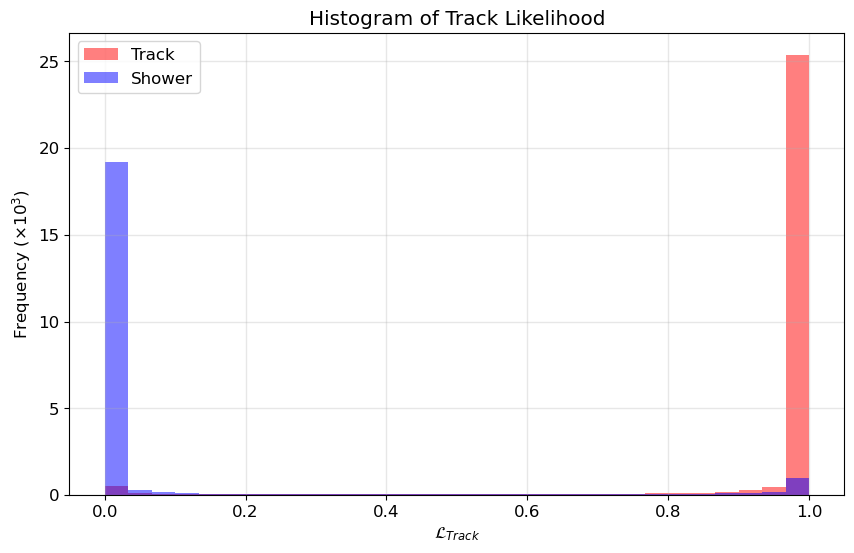

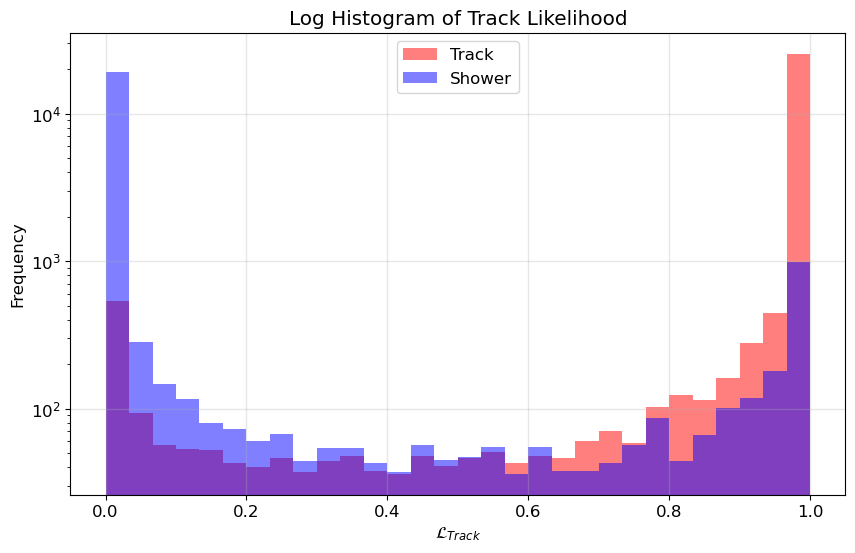

In [5]:
# Plotting the Likelihood Histograms
plt.rcParams.update({'font.size': 12})
import matplotlib.ticker as ticker

def plot_histograms(track_likelihoods):
    """Plots histograms of Track_L and Track_S values for tracks and showers."""
    # Separate Track_L and Track_S values by classification
    track_l_values = [track_l for track_l, track_s, category in track_likelihoods if category == 'track']
    shower_l_values = [track_l for track_l, track_s, category in track_likelihoods if category == 'shower']
    track_s_values = [track_s for track_l, track_s, category in track_likelihoods if category == 'track']
    shower_s_values = [track_s for track_l, track_s, category in track_likelihoods if category == 'shower']

    # Plot Track_L
    plt.figure(figsize=(10, 6))
    plt.hist(track_l_values, bins=30, color='red', alpha=0.5, label='Track')
    plt.hist(shower_l_values, bins=30, color='blue', alpha=0.5, label='Shower')
    plt.xlabel(r'$\mathcal{L}_{Track}$')
    plt.ylabel(r'Frequency $(\times 10^3)$')
    plt.title('Histogram of Track Likelihood')
    plt.legend()
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    # Scale the y-axis by 1/1000
    ax = plt.gca()  # Get current axis
    formatter = ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}')
    ax.yaxis.set_major_formatter(formatter)

    #plt.savefig('TRACK_L', bbox_inches='tight', dpi=300)
    plt.show()

def plot_histograms_log(track_likelihoods):
    """Plots histograms of Track_L and Track_S values for tracks and showers with a logarithmic y-axis."""
    # Separate Track_L and Track_S values by classification
    track_l_values = [track_l for track_l, track_s, category in track_likelihoods if category == 'track']
    shower_l_values = [track_l for track_l, track_s, category in track_likelihoods if category == 'shower']
    track_s_values = [track_s for track_l, track_s, category in track_likelihoods if category == 'track']
    shower_s_values = [track_s for track_l, track_s, category in track_likelihoods if category == 'shower']

    # Plot Track_L with log scale on y-axis
    plt.figure(figsize=(10, 6))
    plt.hist(track_l_values, bins=30, color='red', alpha=0.5, label='Track')
    plt.hist(shower_l_values, bins=30, color='blue', alpha=0.5, label='Shower')
    plt.xlabel(r'$\mathcal{L}_{Track}$')
    plt.ylabel('Frequency')
    plt.title('Log Histogram of Track Likelihood')
    plt.legend()
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    #plt.savefig('TRACK_log(L)', bbox_inches='tight', dpi=300)
    plt.show()

plot_histograms(likelihoods)
plot_histograms_log(likelihoods)

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists for storing predicted and true categories
true_categories = []  # Ground truth (Track vs. Shower)
predicted_categories_noise = []
predicted_categories_correlation = []
predicted_categories_rms = []
predicted_categories_line = []
predicted_categories_q4 = []
predicted_categories_angle = []


# Iterate through events
for event_idx in range(len(events_unseen.reco_hits_w)):
    x_hits = events_unseen.reco_hits_x_w[event_idx]
    w_hits = events_unseen.reco_hits_w[event_idx]

    # quality cut
    if len(w_hits) < 16:
        continue

    # Get predicted probabilities and classification results
    correlation_score = f.correlation(events_unseen, event_idx)
    noise_score = f.noise(events_unseen, event_idx)
    rms_score = f.rms(events_unseen, event_idx)
    line_score = f.line(events_unseen, event_idx)
    q4_score = f.q4_ratio(events_unseen, event_idx)
    angle_score = f.angle(events_unseen, event_idx)

    # True label based on PDG code
    true_label = categorise_event(events_unseen, event_idx, shower_pdg_set)
    true_category = 1 if true_label == "track" else 0
    true_categories.append(true_category)

    # Get probabilities from histograms for Noise, Correlation, and RMS
    if noise_score is not None:
        prob_noise_track, prob_noise_shower = get_probabilities_from_histogram(
            noise_score, noise_bin_edges, noise_track_counts, noise_shower_counts
        )
        predicted_category_noise = 1 if prob_noise_track > prob_noise_shower else 0  # Adjust threshold as needed
        predicted_categories_noise.append(predicted_category_noise)
    else:
        predicted_categories_noise.append(0)  # If no score, classify as Shower by default

    # Correlation classification
    if correlation_score is not None:
        prob_correlation_track, prob_correlation_shower = get_probabilities_from_histogram(
            correlation_score, correlation_bin_edges, correlation_track_counts, correlation_shower_counts
        )
        predicted_category_correlation = 1 if prob_correlation_track > prob_correlation_shower else 0  # Adjust threshold as needed
        predicted_categories_correlation.append(predicted_category_correlation)
    else:
        predicted_categories_correlation.append(0)  # If no score, classify as Shower by default

    # RMS classification
    if rms_score is not None:
        prob_rms_track, prob_rms_shower = get_probabilities_from_histogram(
            rms_score, rms_bin_edges, rms_track_counts, rms_shower_counts
        )
        predicted_category_rms = 1 if prob_rms_track > prob_rms_shower else 0  # Adjust threshold as needed
        predicted_categories_rms.append(predicted_category_rms)
    else:
        predicted_categories_rms.append(0)  # If no score, classify as Shower by default



  # Line classification
    if line_score is not None:
        prob_line_track, prob_line_shower = get_probabilities_from_histogram(
            line_score, line_bin_edges, line_track_counts, line_shower_counts
        )
        predicted_category_line = 1 if prob_line_track > prob_line_shower else 0  # Adjust threshold as needed
        predicted_categories_line.append(predicted_category_line)
    else:
        predicted_categories_line.append(0)  # If no score, classify as Shower by default

  # q4 classification
    if q4_score is not None:
        prob_q4_track, prob_q4_shower = get_probabilities_from_histogram(
            q4_score, q4_bin_edges, q4_track_counts, q4_shower_counts
        )
        predicted_category_q4 = 1 if prob_q4_track > prob_q4_shower else 0  # Adjust threshold as needed
        predicted_categories_q4.append(predicted_category_q4)
    else:
        predicted_categories_q4.append(0)  # If no score, classify as Shower by default

  # q4 classification
    if angle_score is not None:
        prob_angle_track, prob_angle_shower = get_probabilities_from_histogram(
            angle_score, angle_bin_edges, angle_track_counts, angle_shower_counts
        )
        predicted_category_angle = 1 if prob_angle_track > prob_angle_shower else 0  # Adjust threshold as needed
        predicted_categories_angle.append(predicted_category_angle)
    else:
        predicted_categories_angle.append(0)  # If no score, classify as Shower by default



# Generate confusion matrices for each feature
conf_matrix_noise = confusion_matrix(true_categories, predicted_categories_noise)
conf_matrix_correlation = confusion_matrix(true_categories, predicted_categories_correlation)
conf_matrix_rms = confusion_matrix(true_categories, predicted_categories_rms)
conf_matrix_line = confusion_matrix(true_categories, predicted_categories_line)
conf_matrix_q4 = confusion_matrix(true_categories, predicted_categories_q4)
conf_matrix_angle = confusion_matrix(true_categories, predicted_categories_angle)

# Print the confusion matrices
print("Confusion Matrix (Noise):")
print(conf_matrix_noise)
print("\nConfusion Matrix (Correlation):")
print(conf_matrix_correlation)
print("\nConfusion Matrix (RMS):")
print(conf_matrix_rms)
print("\nConfusion Matrix (Line):")
print(conf_matrix_line)
print("\nConfusion Matrix (q4):")
print(conf_matrix_q4)
print("\nConfusion Matrix (angle):")
print(conf_matrix_angle)


# Optionally, display classification reports for each feature
report_noise = classification_report(true_categories, predicted_categories_noise, target_names=["Shower", "Track"])
report_correlation = classification_report(true_categories, predicted_categories_correlation, target_names=["Shower", "Track"])
report_rms = classification_report(true_categories, predicted_categories_rms, target_names=["Shower", "Track"])
report_line = classification_report(true_categories, predicted_categories_line, target_names=["Shower", "Track"])
report_q4 = classification_report(true_categories, predicted_categories_q4, target_names=["Shower", "Track"])
report_angle = classification_report(true_categories, predicted_categories_angle, target_names=["Shower", "Track"])

Confusion Matrix (Noise):
[[10932 11416]
 [ 1811 26433]]

Confusion Matrix (Correlation):
[[20761  1587]
 [ 3530 24714]]

Confusion Matrix (RMS):
[[19906  2442]
 [ 2435 25809]]

Confusion Matrix (Line):
[[19992  2356]
 [  708 27536]]

Confusion Matrix (q4):
[[16345  6003]
 [ 6269 21975]]

Confusion Matrix (angle):
[[19487  2861]
 [ 8104 20140]]


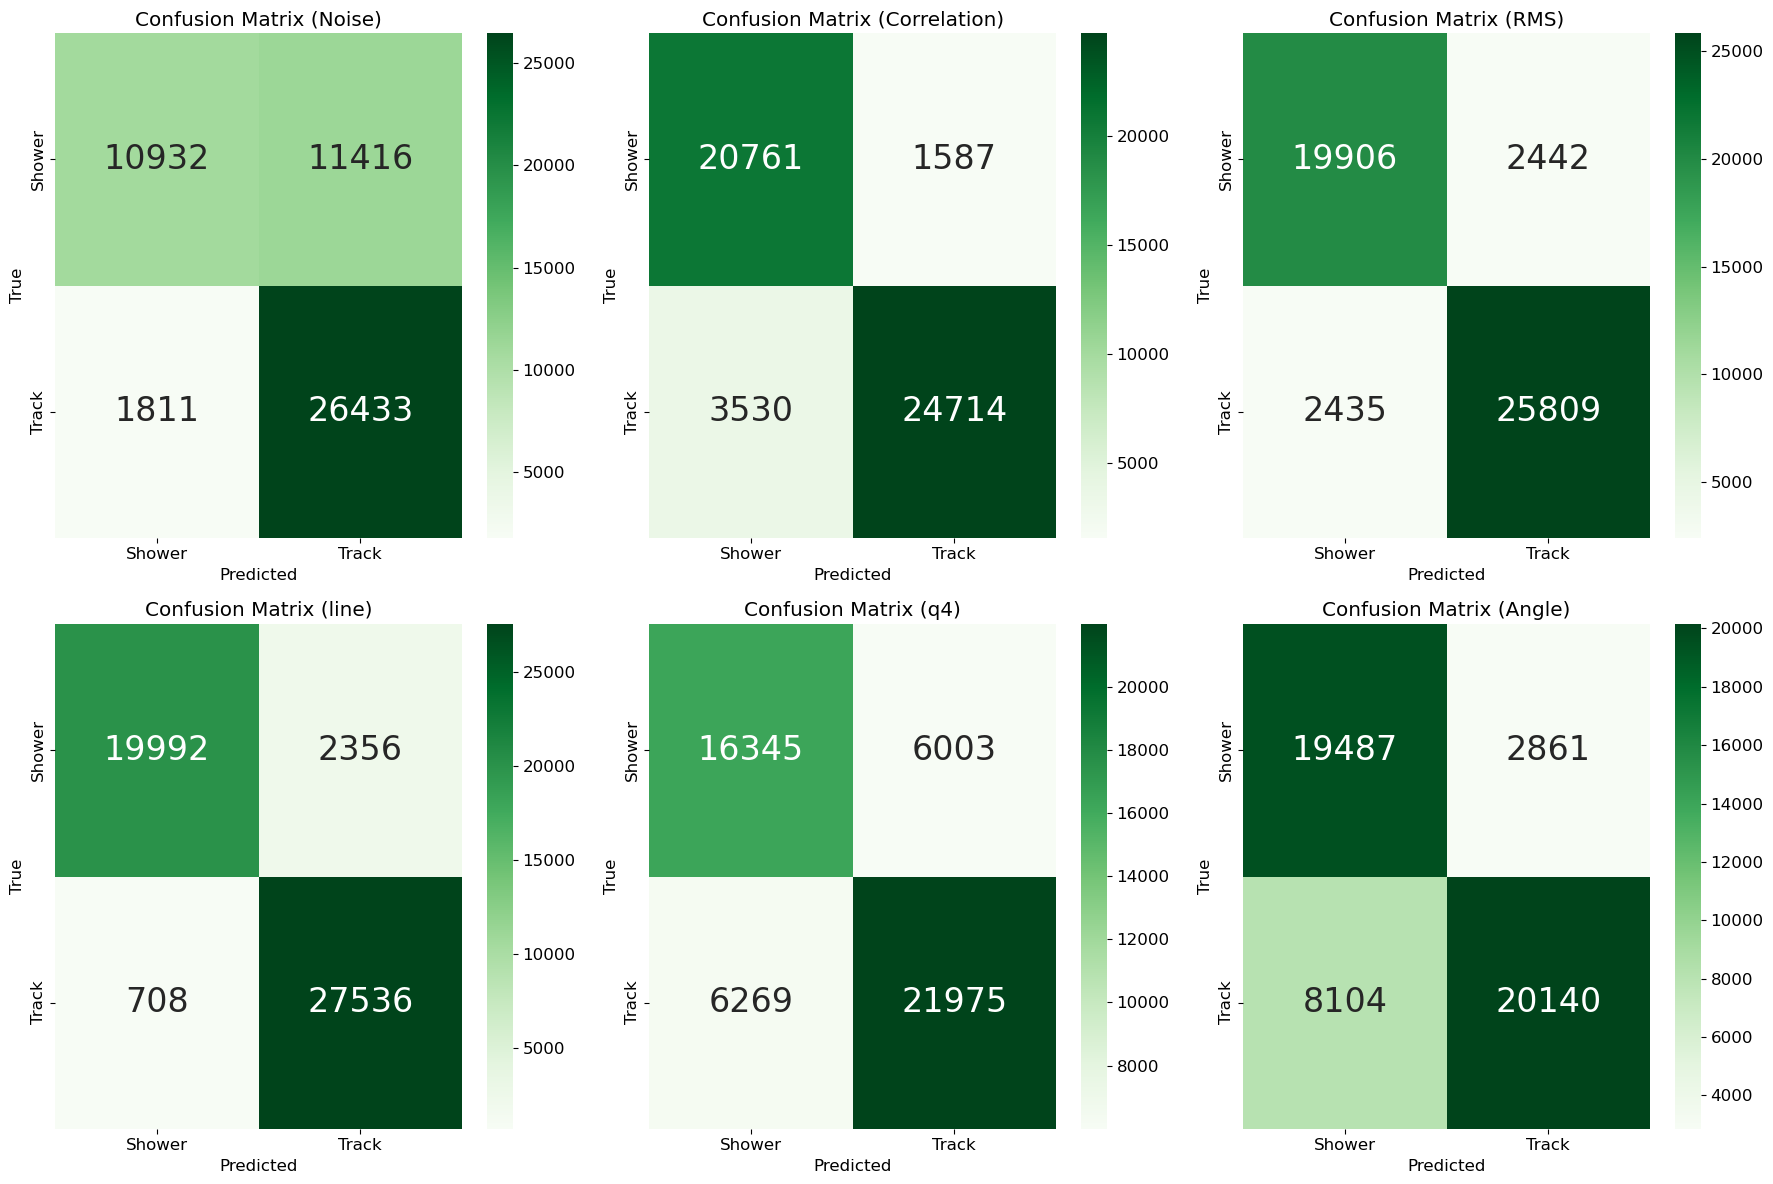

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.rcParams.update({'font.size': 12})
# Create the subplot grid (2x3 layout)
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Create 6 subplots (2 rows, 3 columns)

# Flatten axes for easier indexing
axes = axes.flatten()


# Plot Noise Confusion Matrix
sns.heatmap(conf_matrix_noise, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 24}, 
            xticklabels=["Shower", "Track"], yticklabels=["Shower", "Track"], ax=axes[0])
axes[0].set_title("Confusion Matrix (Noise)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# Plot Correlation Confusion Matrix
sns.heatmap(conf_matrix_correlation, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 24}, 
            xticklabels=["Shower", "Track"], yticklabels=["Shower", "Track"], ax=axes[1])
axes[1].set_title("Confusion Matrix (Correlation)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

# Plot RMS Confusion Matrix
sns.heatmap(conf_matrix_rms, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 24}, 
            xticklabels=["Shower", "Track"], yticklabels=["Shower", "Track"], ax=axes[2])
axes[2].set_title("Confusion Matrix (RMS)")
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("True")

# Plot Additional Confusion Matrix (line)
sns.heatmap(conf_matrix_line, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 24}, 
            xticklabels=["Shower", "Track"], yticklabels=["Shower", "Track"], ax=axes[3])
axes[3].set_title("Confusion Matrix (line)")
axes[3].set_xlabel("Predicted")
axes[3].set_ylabel("True")

# Plot Additional Confusion Matrix (q4)
sns.heatmap(conf_matrix_q4, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 24}, 
            xticklabels=["Shower", "Track"], yticklabels=["Shower", "Track"], ax=axes[4])
axes[4].set_title("Confusion Matrix (q4)")
axes[4].set_xlabel("Predicted")
axes[4].set_ylabel("True")

# Plot Additional Confusion Matrix (angle)
sns.heatmap(conf_matrix_angle, annot=True, fmt='d', cmap='Greens', annot_kws={"size": 24}, 
            xticklabels=["Shower", "Track"], yticklabels=["Shower", "Track"], ax=axes[5])
axes[5].set_title("Confusion Matrix (Angle)")
axes[5].set_xlabel("Predicted")
axes[5].set_ylabel("True")

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure if needed
#plt.savefig('6_conf_matrices.png', bbox_inches='tight', dpi=300)

# Show the plot
plt.show()


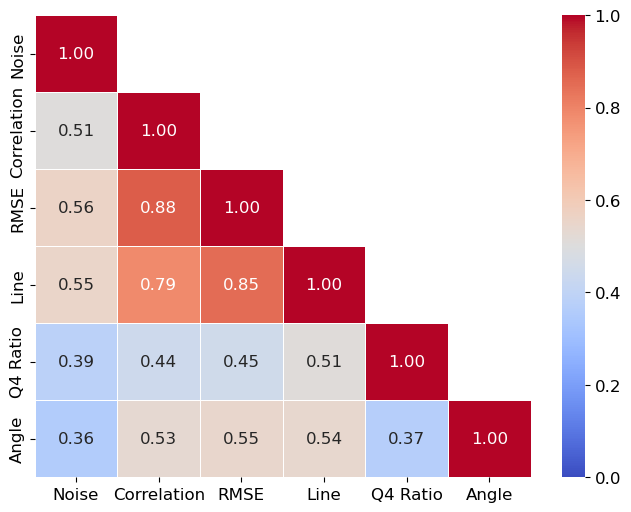

In [8]:
import pandas as pd

data = pd.DataFrame({
    'Noise': predicted_categories_noise,
    'Correlation': predicted_categories_correlation,
    'RMSE': predicted_categories_rms,
    'Line': predicted_categories_line,
    'Q4 Ratio': predicted_categories_q4,
    'Angle': predicted_categories_angle
})

# Compute the correlation matrix
correlation_matrix = data.corr()

# Mask the upper triangle of the correlation matrix
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Plot the heatmap
plt.figure(figsize=(8, 6))  # Optional: change the figure size
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=0, vmax=1, annot_kws={"size": 12})
#plt.savefig('corr_matrix3.png', bbox_inches='tight', dpi=300)  # Save as PNG

# Show the plot
plt.show()

In [9]:
print("\nClassification Report (Noise):")
print(report_noise)
print("\nClassification Report (Correlation):")
print(report_correlation)
print("\nClassification Report (RMS):")
print(report_rms)
print("\nClassification Report (line):")
print(report_line)
print("\nClassification Report (q4):")
print(report_q4)
print("\nClassification Report (angle):")
print(report_angle)


Classification Report (Noise):
              precision    recall  f1-score   support

      Shower       0.86      0.49      0.62     22348
       Track       0.70      0.94      0.80     28244

    accuracy                           0.74     50592
   macro avg       0.78      0.71      0.71     50592
weighted avg       0.77      0.74      0.72     50592


Classification Report (Correlation):
              precision    recall  f1-score   support

      Shower       0.85      0.93      0.89     22348
       Track       0.94      0.88      0.91     28244

    accuracy                           0.90     50592
   macro avg       0.90      0.90      0.90     50592
weighted avg       0.90      0.90      0.90     50592


Classification Report (RMS):
              precision    recall  f1-score   support

      Shower       0.89      0.89      0.89     22348
       Track       0.91      0.91      0.91     28244

    accuracy                           0.90     50592
   macro avg       0.90     

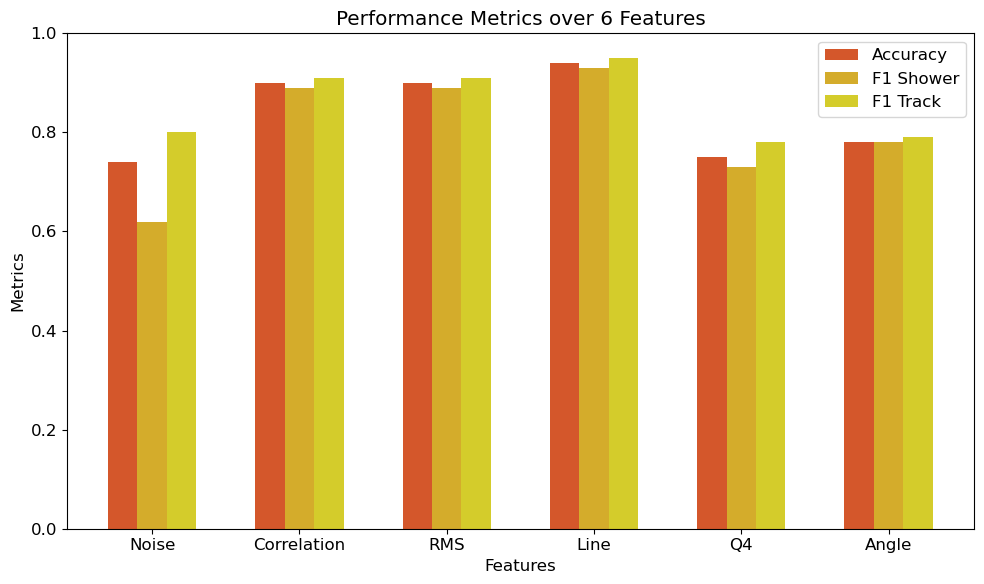

In [10]:
# performance bar graph now
# Data
categories = ['Noise', 'Correlation', 'RMS', 'Line', 'Q4', 'Angle']
accuracies = [0.74, 0.90, 0.90, 0.94, 0.75, 0.78]
f1_shower = [0.62, 0.89, 0.89, 0.93, 0.73, 0.78]
f1_track = [0.80, 0.91, 0.91, 0.95, 0.78, 0.79]

# Bar width
bar_width = 0.2

# X positions
x = np.arange(len(categories))

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(x - bar_width, accuracies, width=bar_width, label='Accuracy', color='#D4572B')
plt.bar(x, f1_shower, width=bar_width, label='F1 Shower', color='#D4AC2B')
plt.bar(x + bar_width, f1_track, width=bar_width, label='F1 Track', color='#D4CC2B')

# Labels and title
plt.xlabel('Features')
plt.ylabel('Metrics')
plt.title('Performance Metrics over 6 Features')
plt.xticks(x, categories)
plt.ylim(0, 1)  # Set the y-axis limit to [0, 1]
plt.legend()

# Show the plot
plt.tight_layout()
#plt.savefig('perf_bars.png', bbox_inches='tight', dpi=300)  # Save as PNG
plt.show()


In [11]:
def calculate_accuracy(events, shower_pdg_set):
    """Calculate the accuracy of the likelihood approach."""
    correct_predictions = 0
    total_valid_events = 0  # Only count events that produce valid predictions

    for event_idx in range(len(events_unseen.reco_hits_w)):

        # Skip events with fewer than 16 hits
        if len(events_unseen.reco_hits_w[event_idx]) < 16:
            continue
        
        # Get ground truth classification
        true_classification = categorise_event(events, event_idx, shower_pdg_set)

        # Get likelihood values
        result = likelihood_approach(events, event_idx, shower_pdg_set)
        if result is not None:
            Track_L, Shower_L, _ = result  # Ignore the true classification returned
            predicted_classification = 'track' if Track_L > Shower_L else 'shower'

            # Increment valid events count
            total_valid_events += 1

            # Compare predicted and true classification
            if predicted_classification == true_classification:
                correct_predictions += 1

    # Calculate accuracy
    accuracy = correct_predictions / total_valid_events if total_valid_events > 0 else 0
    print(correct_predictions)
    print(total_valid_events)
    return accuracy, total_valid_events


# Main script
accuracy, total_valid_events = calculate_accuracy(events_unseen, shower_pdg_set)

KeyboardInterrupt: 

In [ ]:
print(f"Accuracy of the likelihood approach: {accuracy:.2%}")
print(f"Total valid events processed: {total_valid_events}")

In [5]:
plt.rcParams.update({'font.size': 12})
def feature_histogram(arr1, arr2, feature_name='Feature', units='units'):

    n_1 = len(arr1)
    n_2 = len(arr2)

    arrs = np.concatenate((arr1, arr2))
    bin_edges = np.linspace(0, np.max(arrs), 501)

    # Calculate fractional weights for each entry
    weights_1 = np.ones_like(arr1) / n_1 if n_1 > 0 else np.zeros_like(arr1)
    weights_2 = np.ones_like(arr2) / n_2 if n_2 > 0 else np.zeros_like(arr2)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    bin_heights_1, _ = np.histogram(arr1, bins=bin_edges, weights=weights_1)
    bin_heights_2, _ = np.histogram(arr2, bins=bin_edges, weights=weights_2)

    # Plot the histogram with fractional bin heights
    plt.figure(figsize=(10, 6))
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
    plt.hist(arr1, bins=bin_edges, weights=weights_1, color='r', linewidth=0.5, alpha=0.5, label='Tracks')
    plt.axvline(np.mean(arr1), c='r', linewidth=2, label='Mean Track RMSE', alpha=0.7)
    plt.hist(arr2, bins=bin_edges, weights=weights_2, color='b', linewidth=0.5, alpha=0.5, label='Showers')
    plt.axvline(np.mean(arr2), c='b', linewidth=2, label='Mean Shower RMSE', alpha=0.7)
    if units != 'units':
        plt.xlabel(f'{feature_name} Values [{units}]')
    else:
        plt.xlabel(f'{feature_name} Values')
    plt.ylabel('fraction of events')
    plt.legend()
    plt.show()

    return bin_heights_1, bin_heights_2, bin_edges

In [6]:
def pur_eff(counts_1, counts_2, edges):
    counts_1 = np.array(counts_1)
    counts_2 = np.array(counts_2)
    
    if np.mean(counts_1 * edges[:-1]) > np.mean(counts_2 * edges[:-1]):
        positive = counts_1
        negative = counts_2
    else:
        positive = counts_2
        negative = counts_1

    efficiency = []
    purity = []
    
    for i in range(len(edges) - 1):
        sum_positive_right = np.sum(positive[i:])
        sum_negative_right = np.sum(negative[i:])
        sum_all_right = sum_positive_right + sum_negative_right
        sum_positive_all = np.sum(positive)

        # Calculate efficiency
        e = sum_positive_right / sum_positive_all if sum_positive_all > 0 else 0

        # Calculate purity
        p = sum_positive_right / sum_all_right if sum_all_right > 0 else 0

        efficiency.append(e)
        purity.append(p)

    return np.array(efficiency), np.array(purity)

In [7]:
""" features """

def correlation(events, event_idx, min_hits=15):
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx] 

    # Check if there are valid hits
    if len(w_hits) == len(x_hits) and len(w_hits) > min_hits: # talk about advantages and disadvantages of results with a threshold 
        if np.std(x_hits) == 0 or np.std(w_hits) == 0:
            return None  # No valid correlation if there's no variation in data
        
        correlation = np.corrcoef(x_hits, w_hits)[0, 1]
        
        # Fit line using w_hits for x and calculate predicted y-values
        line_fit = np.polyfit(w_hits, x_hits, 1)
        line_y_pred = np.polyval(line_fit, w_hits)
        
        # Calculate line error between predicted and actual x_hits
        line_error = np.mean((x_hits - line_y_pred) ** 2)
        
        # Normalise scores
        correlation_score = abs(correlation) if not np.isnan(correlation) else 0
        error_score = max(0, 1 - line_error / 20) if line_error < 20 else 0
        
        # Weighted score
        line_score = (correlation_score * 0.7) + (error_score * 0.3)
        
        return (line_score * 100)  # Return the score and category

    else:
        return None

def noise(events, event_idx, min_hits=15, eps=2, min_samples=5):
    # Extract hit positions (no pdg filtering, just use reco hits)
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx]

    # Check if there are valid hits
    if len(w_hits) == len(x_hits) and len(w_hits) > min_hits:
        # Combine the coordinates for clustering
        hits_coordinates = np.column_stack((w_hits, x_hits))

        # Apply DBSCAN clustering
        db = DBSCAN(eps=eps, min_samples=min_samples).fit(hits_coordinates)
        labels = db.labels_

        # Count noise points (labeled as -1)
        n_noise = np.sum(labels == -1)

        # Count clusters (unique labels excluding -1)
        unique_clusters = set(labels) - {-1}
        n_clusters = len(unique_clusters)

        return n_noise + n_clusters
    else:
        return None
        
def rms(events, event_idx, min_hits=15):
    w_hits = events.reco_hits_w[event_idx]
    x_hits = events.reco_hits_x_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > min_hits:
        slope, intercept = np.polyfit(w_hits, x_hits, 1)
        
        actual = x_hits
        predicted = slope * w_hits + intercept
        
        meanSquaredError = ((predicted - actual) ** 2).mean()
        return np.sqrt(meanSquaredError)
    else: 
        return None 
        
def angle(events, event_idx, min_hits=15):
    x_hits = events.reco_hits_x_w[event_idx]
    w_hits = events.reco_hits_w[event_idx]

    if len(w_hits) == len(x_hits) and len(w_hits) > min_hits:
        # Fit the best-fit line
        line_fit = np.polyfit(w_hits, x_hits, 1)
        line_slope = line_fit[0]
        line_intercept = line_fit[1]

        # Calculate residuals (distance from the line)
        line_y_pred = np.polyval(line_fit, w_hits)
        residuals = np.abs(x_hits - line_y_pred)

        # Find the index of the furthest point
        furthest_idx = np.argmax(residuals)
        furthest_point = np.array([x_hits[furthest_idx], w_hits[furthest_idx]])

        # Start of the line is at the minimum W-coordinate
        min_w = np.min(w_hits)
        start_point = np.array([line_slope * min_w + line_intercept, min_w])

        # End of the red line (best-fit line) at the maximum W-coordinate
        max_w = np.max(w_hits)
        end_of_red_line = np.array([line_slope * max_w + line_intercept, max_w])

        # Calculate the lengths of the three sides of the triangle
        red_line_length = np.linalg.norm(end_of_red_line - start_point)  # Distance between start and end of red line
        purple_line_length = np.linalg.norm(furthest_point - start_point)  # Distance between start and furthest point (purple line)
        third_line_length = np.linalg.norm(furthest_point - end_of_red_line)  # Distance between end of red line and furthest point (third line)

        # Using the cosine rule to calculate the angle between the red and purple lines
        cos_theta = (red_line_length**2 + purple_line_length**2 - third_line_length**2) / (2 * red_line_length * purple_line_length)
        angle_radians = np.arccos(np.clip(cos_theta, -1.0, 1.0))  # Clip value to avoid out-of-bound errors
        angle_degrees = np.degrees(angle_radians)  # Convert radians to degrees
        
        return angle_degrees
    else:
        return None
        
def line(events, event_idx, min_hits=15):
    w_hits = np.array(events.reco_hits_w[event_idx])
    x_hits = np.array(events.reco_hits_x_w[event_idx])

    if len(w_hits) == len(x_hits) and len(w_hits) > 15:
    
        # Calculate differences between consecutive points
        dx = np.diff(w_hits)
        dy = np.diff(x_hits)
    
        # Compute segment lengths
        segment_lengths = np.sqrt(dx**2 + dy**2)
    
        # Total arc length (line integral)
        total_length = np.sum(segment_lengths)
    
        # Normalize by the number of points
        normalised_length = total_length / len(w_hits)

        return normalised_length
    else:
        return None 
        
def q4(events, event_idx, min_hits=15):
    adcs = events.reco_adcs_w[event_idx]

    if len(adcs) > 15:

        q4_idx = len(adcs) // 4

        adcs_q4 = adcs[-q4_idx:]
    
        ratio = sum(adcs_q4) / sum(adcs)
    
    
        return ratio
    else:
       return None

In [8]:
def feature_array_TS(events, feature_func):
    n = len(events.event_number)

    arr_T = []
    arr_S = []

    for i in range(n):
        if len(events.reco_hits_w) < 16:
            continue
        pdg = events.mc_pdg[i]
        result = feature_func(events, i)
        if result is None:
            continue
        if pdg in [-11, 11, 22]:
            arr_S.append(result)
        else: arr_T.append(result)

    return np.array(arr_T), np.array(arr_S)

In [9]:
events_unseen = 0
cheated_0 = Events("CheatedRecoFile_0.root")

In [10]:
c_arr1, c_arr2 = feature_array_TS(cheated_0, correlation)
n_arr1, n_arr2 = feature_array_TS(cheated_0, noise)
r_arr1, r_arr2 = feature_array_TS(cheated_0, rms)
a_arr1, a_arr2 = feature_array_TS(cheated_0, angle)
l_arr1, l_arr2 = feature_array_TS(cheated_0, line)
q_arr1, q_arr2 = feature_array_TS(cheated_0, q4)

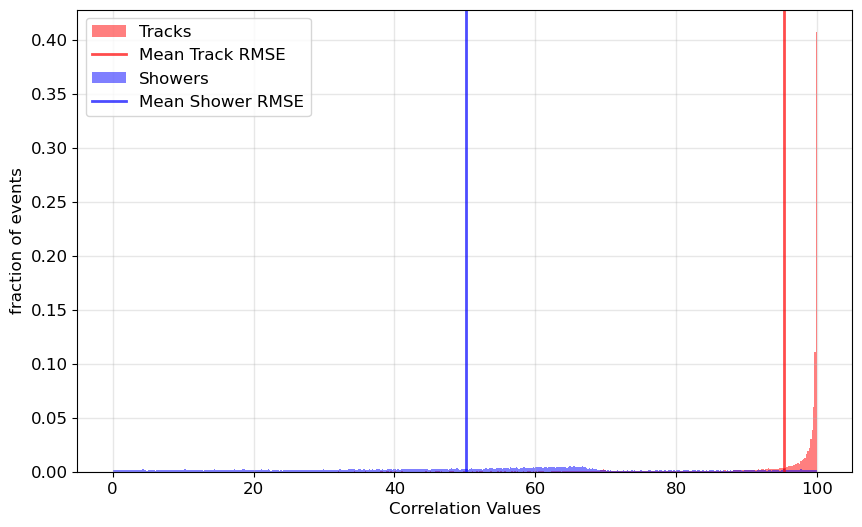

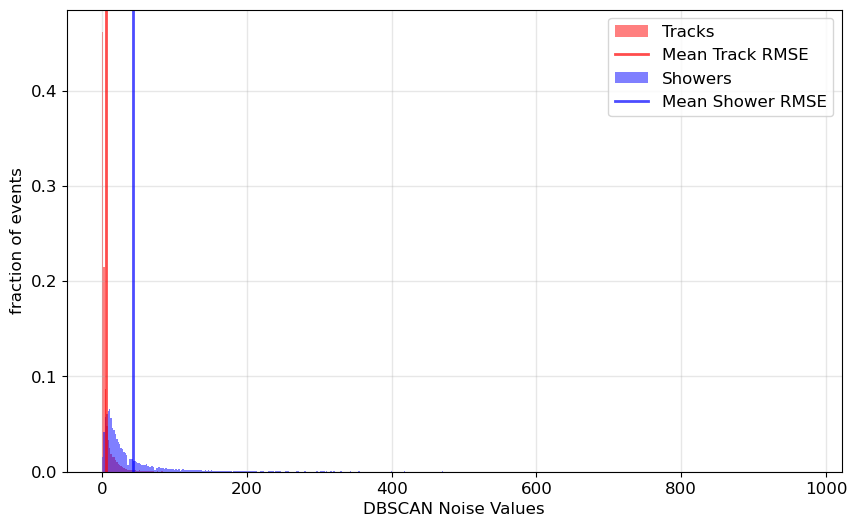

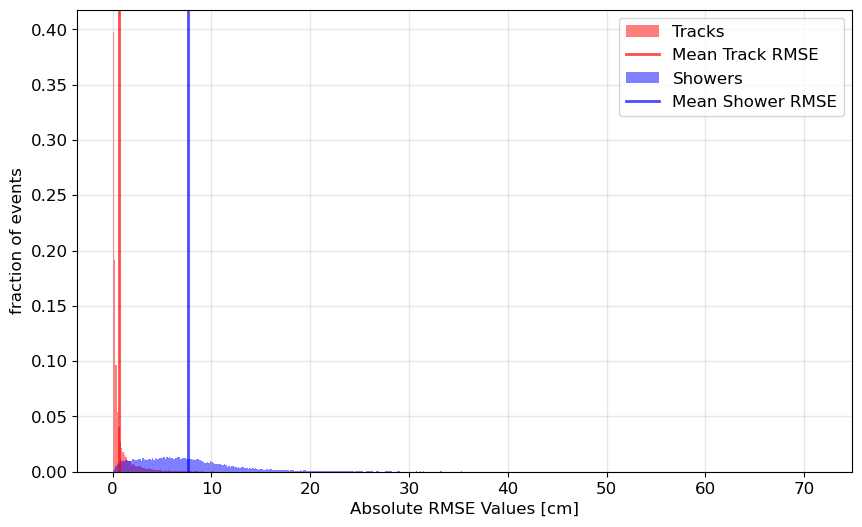

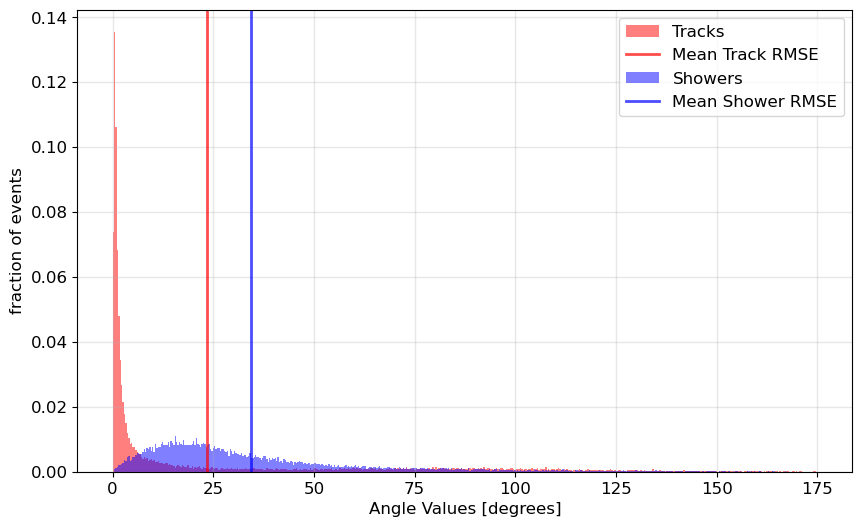

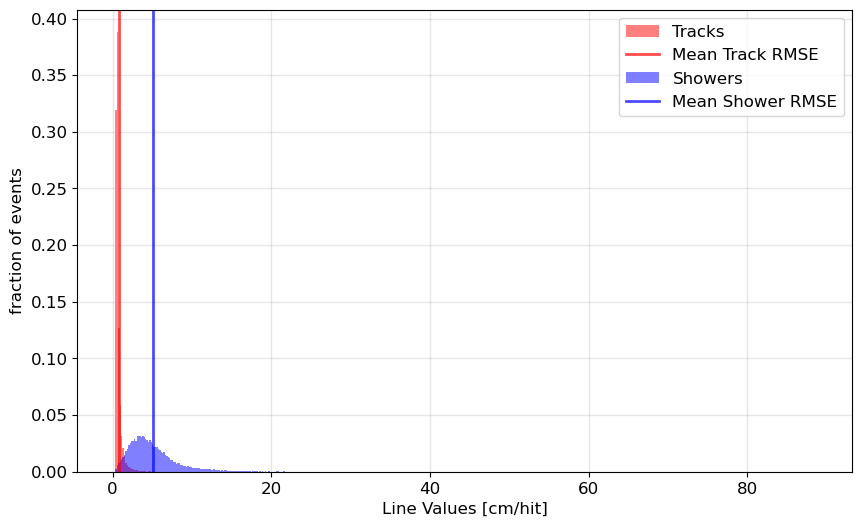

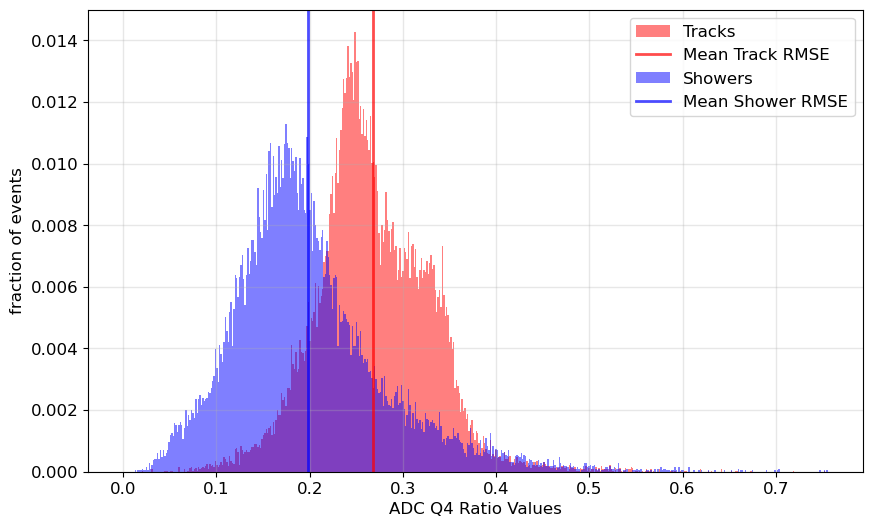

In [11]:
c_counts_1, c_counts_2, c_edges = feature_histogram(c_arr1, c_arr2, feature_name='Correlation')
n_counts_1, n_counts_2, n_edges = feature_histogram(n_arr1, n_arr2, feature_name='DBSCAN Noise')
r_counts_1, r_counts_2, r_edges = feature_histogram(r_arr1, r_arr2, feature_name='Absolute RMSE', units='cm')
a_counts_1, a_counts_2, a_edges = feature_histogram(a_arr1, a_arr2, feature_name='Angle', units='degrees')
l_counts_1, l_counts_2, l_edges = feature_histogram(l_arr1, l_arr2, feature_name='Line', units='cm/hit')
q_counts_1, q_counts_2, q_edges = feature_histogram(q_arr1, q_arr2, feature_name='ADC Q4 Ratio')

In [12]:
c_eff, c_pur = pur_eff(c_counts_1, c_counts_2, c_edges)
n_eff, n_pur = pur_eff(n_counts_1, n_counts_2, n_edges)
r_eff, r_pur = pur_eff(r_counts_1, r_counts_2, r_edges)
a_eff, a_pur = pur_eff(a_counts_1, a_counts_2, a_edges)
l_eff, l_pur = pur_eff(l_counts_1, l_counts_2, l_edges)
q_eff, q_pur = pur_eff(q_counts_1, q_counts_2, q_edges)

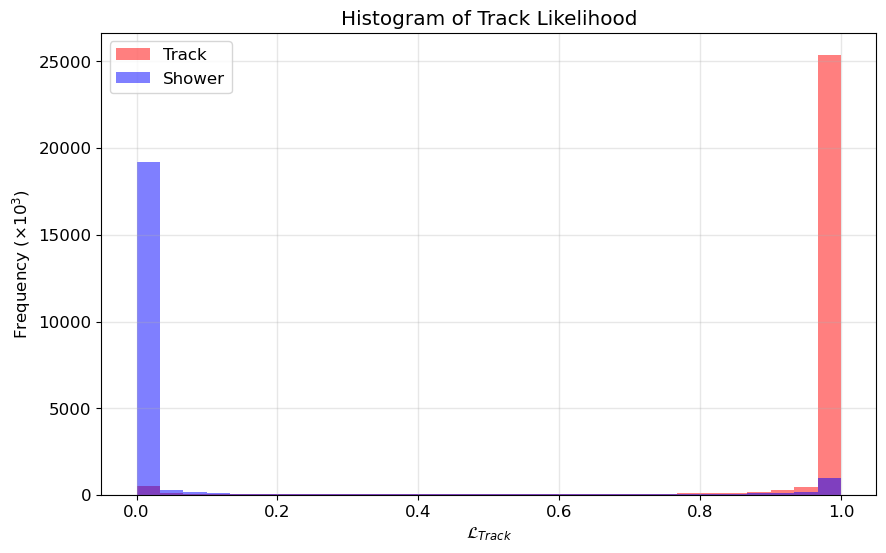

In [13]:
def plot_histograms(track_likelihoods):
    """Plots histograms of Track_L and Track_S values for tracks and showers."""
    # Separate Track_L and Track_S values by classification
    track_l_values = [track_l for track_l, track_s, category in track_likelihoods if category == 'track']
    shower_l_values = [track_l for track_l, track_s, category in track_likelihoods if category == 'shower']
    track_s_values = [track_s for track_l, track_s, category in track_likelihoods if category == 'track']
    shower_s_values = [track_s for track_l, track_s, category in track_likelihoods if category == 'shower']

    # Plot Track_L
    plt.figure(figsize=(10, 6))
    plt.hist(track_l_values, bins=30, color='red', alpha=0.5, label='Track')
    plt.hist(shower_l_values, bins=30, color='blue', alpha=0.5, label='Shower')
    plt.xlabel(r'$\mathcal{L}_{Track}$')
    plt.ylabel(r'Frequency $(\times 10^3)$')
    plt.title('Histogram of Track Likelihood')
    plt.legend()
    plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)

    plt.show()

    return track_l_values, shower_l_values

track_l, shower_l = plot_histograms(likelihoods)

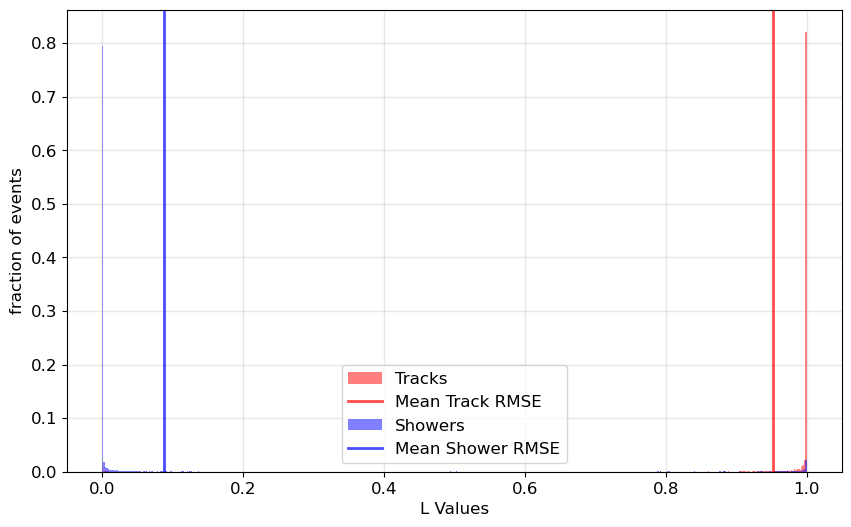

In [14]:
Lt, Ls, L_edges = feature_histogram(track_l, shower_l, feature_name='L')
Likelihood_eff, Likelihood_pur = pur_eff(Lt, Ls, L_edges)

np.savez('eff_pur.npz', 
        c_eff=c_eff, c_pur=c_pur,
        n_eff=n_eff, n_pur=n_pur,
        r_eff=r_eff, r_pur=r_pur,
        a_eff=a_eff, a_pur=a_pur,
        l_eff=l_eff, l_pur=l_pur,
        q_eff=q_eff, q_pur=q_pur,
        Likelihood_eff=Likelihood_eff, Likelihood_pur=Likelihood_pur)

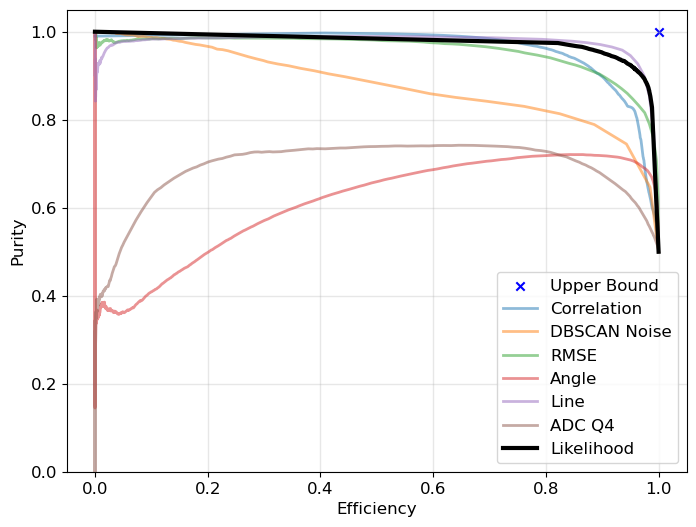

In [26]:
# Load the .npz file
data = np.load('eff_pur.npz')

# Extract the arrays
c_eff = data['c_eff']
c_pur = data['c_pur']
n_eff = data['n_eff']
n_pur = data['n_pur']
r_eff = data['r_eff']
r_pur = data['r_pur']
a_eff = data['a_eff']
a_pur = data['a_pur']
l_eff = data['l_eff']
l_pur = data['l_pur']
q_eff = data['q_eff']
q_pur = data['q_pur']
Likelihood_eff = data['Likelihood_eff']
Likelihood_pur = data['Likelihood_pur']

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(8,6))
plt.scatter(1, 1, marker='x', label='Upper Bound', c='b')
plt.plot(np.append(c_eff, 0), np.append(c_pur, 0.99), linewidth=2, label='Correlation', alpha=0.5)
plt.plot(n_eff, n_pur, linewidth=2, label='DBSCAN Noise', alpha=0.5)
plt.plot(r_eff, r_pur, linewidth=2, label='RMSE', alpha=0.5)
plt.plot(a_eff, a_pur, linewidth=2, label='Angle', alpha=0.5)
plt.plot(l_eff, l_pur, linewidth=2, label='Line', alpha=0.5)
plt.plot(q_eff, q_pur, linewidth=2, label='ADC Q4', alpha=0.5)
plt.plot(np.append(Likelihood_eff, 0), np.append(Likelihood_pur, 1), linewidth=3, label='Likelihood', c='k')
plt.grid(visible=True, which='major', axis='both', linestyle='-', linewidth=1.0, alpha=0.3)
plt.ylim(bottom=0)
plt.xlabel('Efficiency')
plt.ylabel('Purity')
plt.legend()
plt.show()

In [24]:
def auc(eff, pur):
    """
    Calculate the Area Under Curve (AUC) for an Efficiency vs Purity curve.

    Parameters:
    - eff: Array of efficiency values (x-axis)
    - pur: Array of purity values (y-axis)

    Returns:
    - AUC: Scalar value representing the area under the efficiency-purity curve.
    """
    # Sort the arrays by efficiency (x-axis) to avoid negative area
    sort_idx = np.argsort(eff)
    eff = eff[sort_idx]
    pur = pur[sort_idx]
    
    # Calculate the area under the curve
    return np.trapz(pur, x=eff)

import matplotlib.pyplot as plt
import numpy as np

def plot_auc_bars(*eff_pur_sets, labels=None):
    """
    Plots a bar graph comparing the AUC (Area Under Curve) for multiple
    efficiency-purity curves, with the AUC values displayed above the bars.

    Parameters:
    - *eff_pur_sets: Variable number of (efficiency, purity) tuples.
    - labels: List of labels for each pair of arrays. Should match the number of sets.
    """
    auc_values = []
    colors = []
    
    def_colours = plt.cm.tab10.colors

    # Calculate AUC for each pair
    for i, (eff, pur) in enumerate(eff_pur_sets):
        auc_value = auc(eff, pur)
        auc_values.append(auc_value)

        # If it's the "Likelihood" set, color it black
        if labels and labels[i] == 'Likelihood':
            colors.append('k')
        else:
            colors.append(def_colours[i])

    # Plot bar graph
    if labels is None:
        labels = [f'Set {i+1}' for i in range(len(eff_pur_sets))]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(labels, auc_values, color=colors, edgecolor='black')

    for i, bar in enumerate(bars):
        # If it's the "Likelihood" set, set alpha to 0.5, else 0.9
        if labels[i] == 'Likelihood':
            bar.set_alpha(0.9)
        else:
            bar.set_alpha(0.5)

    # Add AUC values on top of each bar
    for bar, auc_value in zip(bars, auc_values):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f'{auc_value:.3f}', 
                 ha='center', fontsize=12)

    # Labeling
    plt.ylabel('---------------- Area Under Curve (AUC) ----------------')
    plt.xlabel('------------------------------------------------ Track/shower Classifier ------------------------------------------------')
    plt.ylim(bottom=0.5)
    plt.show()


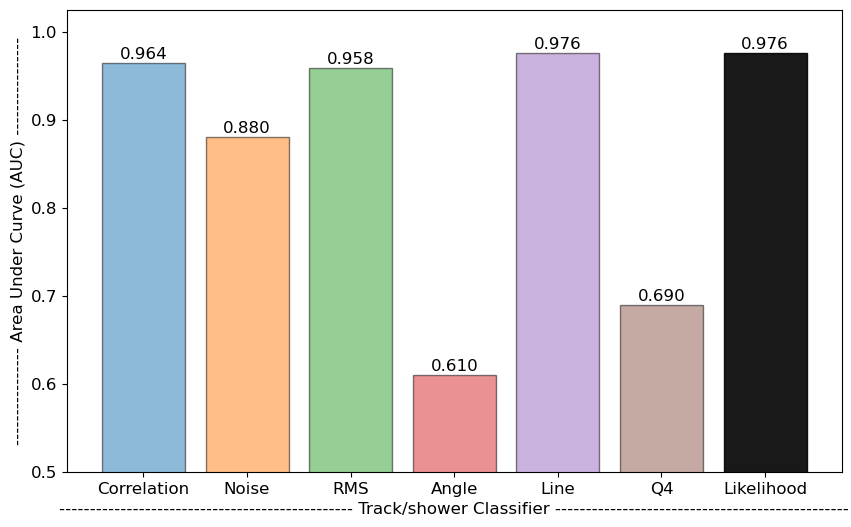

In [25]:
plot_auc_bars(
    (np.append(c_eff, 0), np.append(c_pur, 0.99)),
    (n_eff, n_pur),
    (r_eff, r_pur),
    (a_eff, a_pur),
    (l_eff, l_pur),
    (q_eff, q_pur),
    (np.append(Likelihood_eff, 0), np.append(Likelihood_pur, 1)),
    labels=['Correlation', 'Noise', 'RMS', 'Angle', 'Line', 'Q4', 'Likelihood']
)